# Lab Five: Wide and Deep Networks

***Md Mahfuzur Rahman, Will Schneider, Nik Zelenikovski***



## 1. Preparation

In [88]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)

df = pd.read_csv('salaries.csv') # read in the csv file

print(df.info())
print('===========')
# note that the describe function defaults to using only some variables
print(df.describe())
print('===========')

print(df.select_dtypes(include=['object']).nunique().sum(),"unique class variables")
print('===========')

# create a data description table
data_des = pd.DataFrame()
#code adapted from sample Lab 1 Submission
data_des['Features'] = df.columns
data_des['Description'] = ['Work Year', 'Position Experience Level',
                          'Employment Type', 'Job Title',
                          'Position Salary', 'Currency of Salary',
                          'Position Salary (USD)', 'Employee Residence',
                          'Percentage of Job Responsibilities Completed Remotely', 'Company Location', 'Company Size']
data_des['Scales'] = ['interval'] + ['ordinal'] + ['nominal']*2 + ['ratio'] + ['nominal']+ ['ratio'] + ['nominal'] + ['ratio'] + ['nominal'] + ['ordinal']
data_des['Discrete\Continuous'] = ['continuous'] + ['discrete']*3 + ['continuous'] + \
                                  ['discrete'] + ['continuous'] + ['discrete'] + ['continuous'] + ['discrete']*2
data_des['Unique Values'] = df[df.columns].nunique().values
data_des

#==================================================================
from sklearn import __version__ as sklearn_version
if sklearn_version < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
from copy import deepcopy

X = df.drop(columns = ['salary','salary_in_usd'])
y = df['salary_in_usd']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
training = deepcopy(pd.concat([X_train, y_train], axis =1))
testing = deepcopy(pd.concat([X_test, y_test], axis =1))

training.dropna(inplace=True)
training.reset_index(inplace=True, drop = True)
testing.dropna(inplace=True)
testing.reset_index(inplace=True, drop = True)
datas = [training, testing]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23710 entries, 0 to 23709
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           23710 non-null  int64 
 1   experience_level    23710 non-null  object
 2   employment_type     23710 non-null  object
 3   job_title           23710 non-null  object
 4   salary              23710 non-null  int64 
 5   salary_currency     23710 non-null  object
 6   salary_in_usd       23710 non-null  int64 
 7   employee_residence  23710 non-null  object
 8   remote_ratio        23710 non-null  int64 
 9   company_location    23710 non-null  object
 10  company_size        23710 non-null  object
dtypes: int64(4), object(7)
memory usage: 2.0+ MB
None
          work_year        salary  salary_in_usd  remote_ratio
count  23710.000000  2.371000e+04   23710.000000  23710.000000
mean    2023.460565  1.618500e+05  151918.919823     27.954450
std        0.693803  2.

### 1.1 Class Variable Definition and Dataset Preparation for Classification/Regression

Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). You have the option of using tf.dataset for processing, but it is not required.

#### Class Variables
This dataset has 8 features with class variables. Three of the features have n > 20 unique classes, which will be reduced through embedding later in this notebook. 'remote_ratio' is a numeric feature with three values in the dataset indicating the percentage of remote work. The available values are 0, 50, 100. The data source considers these values labeled (0: Non-Remote, Hybrid, & Fully Remote. These will be converted to categorical features in the code below. A  description of all the datatypes is in the code output below. In total, the 371 unique classes exist within categorical features. These will need to be processed for dimensionality reduction and embedding into the model. Additionally, two of the categorical features resemble ordinality, even expressed in the name of the features 'company_**size**' & 'experience_**level**'. They also have low cardinality. These will be converted to labeled variables and they will be crossed with other categorical columns later in this notebook.

#### Pre-Processing with TensorFlow

##### Ordinal Variables & Target-Variable Normalization

In [89]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# Encode ordinal features
# Custom order for ordinal encoding
exp_mapping = {'EN':0, 'MI':1, 'SE':2,'EX':3}
training['experience_level'] = training['experience_level'].map(exp_mapping)
testing['experience_level'] = testing['experience_level'].map(exp_mapping)

size_mapping = {'S': 0, 'M': 1, 'L': 2}
training['company_size'] = training['company_size'].map(size_mapping)
testing['company_size'] = testing['company_size'].map(size_mapping)

le = LabelEncoder()
training['remote_ratio'] = le.fit_transform(training['remote_ratio'])
testing['remote_ratio'] = le.transform(testing['remote_ratio'])

#Normalize the Target Variable (Salary in USD)
scaler = StandardScaler()
salary = 'salary_in_usd'
training['salary_in_usd'] = scaler.fit_transform(training[['salary_in_usd']])
testing['salary_in_usd'] = scaler.transform(testing[['salary_in_usd']])

In [90]:
# ========================================================
# define variables that should be encoded as integers
categorical_headers = ['company_location','employee_residence',
                       'employment_type','job_title','salary_currency','experience_level','company_size']

# get unique values in each feature
for col in categorical_headers:
    print(f'{col} has {len(training[col].unique())} unique values.')
print("\n===================\n")

# ========================================================
# define variables that should be scaled or made discrete
numeric_headers = ['work_year', 'remote_ratio']
for data in datas:
    data[numeric_headers] = data[numeric_headers].to_numpy().astype(float)

#get the number of unique values per column
cols_of_interest = ['company_size','company_location', 'employee_residence','experience_level',
                    'employment_type','job_title','salary_currency']
unique_counts = df[cols_of_interest].nunique()

print(unique_counts,"\n")

company_location has 75 unique values.
employee_residence has 84 unique values.
employment_type has 4 unique values.
job_title has 163 unique values.
salary_currency has 23 unique values.
experience_level has 4 unique values.
company_size has 3 unique values.


company_size            3
company_location       78
employee_residence     89
experience_level        4
employment_type         4
job_title             169
salary_currency        24
dtype: int64 



##### Create a TF Dataset

In [91]:
# !python.exe -m pip install --upgrade pip
# !pip install --upgrade tensorflow
# !pip install --upgrade keras
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import metrics as mt
import tensorflow as tf
from tensorflow import keras
import sys

print(tf.__version__)
#print(keras.__version__)
print(sys.version)

from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# create a tensorflow dataset, for ease of use later
batch_size = 64

def create_dataset_from_dataframe(df_input):

    df = df_input.copy()
    #Regression
    labels = df.pop('salary_in_usd')
    # #Classification
    # labels = df[entercolumnhere]

    df = {key: value.values[:,np.newaxis] for key, value in df_input[categorical_headers+numeric_headers].items()}

    # create the Dataset here
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))

    # now enable batching and prefetching
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds

ds_train = create_dataset_from_dataframe(training)
ds_test = create_dataset_from_dataframe(testing)


2.16.1
3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]


In [99]:
ds_train

<_PrefetchDataset element_spec=({'company_location': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'employee_residence': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'employment_type': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'job_title': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'salary_currency': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'experience_level': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'company_size': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'work_year': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'remote_ratio': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [92]:
from tensorflow.keras.utils import FeatureSpace

# Example One: Just lump everything together, and concatenate
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        # "experience_level": FeatureSpace.string_categorical(num_oov_indices=0),
        "employment_type": FeatureSpace.string_categorical(num_oov_indices=0,),
        "job_title": FeatureSpace.string_categorical(num_oov_indices=1),
        "salary_currency": FeatureSpace.string_categorical(num_oov_indices=1),
        "employee_residence": FeatureSpace.string_categorical(num_oov_indices=1),
        "company_location": FeatureSpace.string_categorical(num_oov_indices=1),

        # Categorical feature encoded as integers
        "remote_ratio": FeatureSpace.integer_categorical(num_oov_indices=0),
        "company_size": FeatureSpace.integer_categorical(num_oov_indices=0),
        "experience_level": FeatureSpace.integer_categorical(num_oov_indices=0),

        # Numerical features to normalize (normalization will be learned)
        # learns the mean, variance, and if to invert (3 parameters)
        # "salary_in_usd": FeatureSpace.float_normalized(),

        "work_year": FeatureSpace.float_normalized()
            },
    output_mode="concat", # can also be a dict, processed internally
)

# now that we have specified the preprocessing, let's run it on the data

# create a version of the dataset that can be iterated without labels
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels) # inititalize the feature map to this data

# the adapt function allows the model to learn one-hot encoding sizes
# now define a preprocessing operation that returns the processed features
preproc_ds_train = ds_train.map(lambda x, y: (feature_space(x), y),
                                     num_parallel_calls=tf.data.AUTOTUNE)
# run it so that we can use the pre-processed data
preproc_ds_train = preproc_ds_train.prefetch(tf.data.AUTOTUNE)

# do the same for the test set
preproc_ds_test = ds_test.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preproc_ds_test = preproc_ds_test.prefetch(tf.data.AUTOTUNE)

In [106]:
ds_train

<_PrefetchDataset element_spec=({'company_location': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'employee_residence': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'employment_type': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'job_title': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'salary_currency': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'experience_level': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'company_size': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'work_year': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'remote_ratio': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

#### Dimensionality Reduction (Square Root Heuristic)

In TensorFlow, embeddings are used to convert categorical data into continuous vector spaces, where similar categories are mapped closer together. The embedding layer in TensorFlow is a trainable layer that learns a fixed-size continuous vector representation for each category. This is especially useful for high cardinality categorical features. By choosing to embed certain classes with high cardinality, we reduced the dimensionality of the dataset. This was particularly useful in Keras, as the only real requirement is to encode the data one-hot.

In [100]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Identify groups of features for cross-product
cross_product_features = [('job_title', 'location')]
print(f"Selected cross-product features: {cross_product_features}")
# Identify groups of features for cross-product
cross_product_features = ['job_title', 'location']
print(f"Selected cross-product features: {cross_product_features}")

# Metrics for evaluation
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score)

# Choose the cross-validation method
cv = StratifiedKFold(n_splits=10)

# Create and evaluate the model using cross-validation
model = LogisticRegression()
precision_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=precision_scorer)
recall_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=recall_scorer)
f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)

print(f"Mean Absolute Error: {precision_scores.mean()}")
print(f"Root Mean Squared Error: {recall_scores.mean()}")
print(f"Root Mean Squared Error: {f1_scores.mean()}")
# Use StratifiedShuffleSplit to ensure balanced class distribution
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

Selected cross-product features: [('job_title', 'location')]
Selected cross-product features: ['job_title', 'location']


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\wschneider\anaconda3\envs\cs7324_env\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\wschneider\anaconda3\envs\cs7324_env\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\wschneider\anaconda3\envs\cs7324_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1201, in fit
    X, y = self._validate_data(
  File "C:\Users\wschneider\anaconda3\envs\cs7324_env\lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\wschneider\anaconda3\envs\cs7324_env\lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
  File "C:\Users\wschneider\anaconda3\envs\cs7324_env\lib\site-packages\sklearn\utils\validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "C:\Users\wschneider\anaconda3\envs\cs7324_env\lib\site-packages\sklearn\utils\_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "C:\Users\wschneider\anaconda3\envs\cs7324_env\lib\site-packages\pandas\core\generic.py", line 2150, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'SE'


In [101]:
from tensorflow.keras.layers import Embedding, Flatten, Lambda

def setup_embedding_from_categorical(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = len(feature_space.preprocessors[col_name].get_vocabulary())

    # get the output from the feature space, which is input to embedding
    x = feature_space.preprocessors[col_name].output

    # now use an embedding to deal with integers from feature space
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col_name+'_embed')(x)

    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)

    return x # return the tensor here

In [102]:
#!pip install pydot
#!pip install graphviz
# these are the placeholder inputs in the computation graph BEFORE
# applying and transformations
dict_inputs = feature_space.get_inputs()  #getting inputs is WAY easier now

# these are the encoded features after they have been processed
# We can use these as additional inpits into the computation graph
encoded_features = feature_space.get_encoded_features() # these features have been encoded

# using feature space above, this will result in 131 concatenated features
# this is calucalted based on the one-hot encodings for each category

# now lets create some layers with Keras
x = keras.layers.Dense(64, activation="relu")(encoded_features)
x = keras.layers.Dense(32, activation="relu")(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

# we can now create two input/outputs to the computation graph

# this expects features already transformed
training_model = keras.Model(inputs=encoded_features,
                             outputs=predictions)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

# this expects features that are not transformed
inference_model = keras.Model(inputs=dict_inputs,
                              outputs=predictions)
inference_model.compile(loss="binary_crossentropy", metrics=["accuracy"])

inference_model.summary()

# plot_model(
#     training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
#     rankdir='LR', expand_nested=False, dpi=96
# )

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ company_location    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ company_size        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employee_residence  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employment_type     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ experience_level    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_title           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ remote_ratio        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salary_currency     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ company_location… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ integer_categorica… │ (None, 1)         │          0 │ company_size[0][… │
│ (IntegerLookup)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ employee_residen… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ employment_type[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ integer_categorica… │ (None, 1)         │          0 │ experience_level… │
│ (IntegerLookup)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ job_title[0][0]   │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ integer_categorica… │ (None, 1)         │          0 │ remote_ratio[0][… │
│ (IntegerLookup)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ salary_currency[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ work_year           │ (None, 1)         │          0 │ -               

 Total params: 25,476 (99.52 KB)

 Trainable params: 25,473 (99.50 KB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/5
297/297 - 0s - 1ms/step - accuracy: 0.0000e+00 - loss: -8.0140e+04 - val_accuracy: 0.0000e+00 - val_loss: -8.8389e+04
Epoch 2/5
297/297 - 0s - 1ms/step - accuracy: 0.0000e+00 - loss: -1.0089e+05 - val_accuracy: 0.0000e+00 - val_loss: -1.1007e+05
Epoch 3/5
297/297 - 1s - 2ms/step - accuracy: 0.0000e+00 - loss: -1.2439e+05 - val_accuracy: 0.0000e+00 - val_loss: -1.3449e+05
Epoch 4/5
297/297 - 1s - 2ms/step - accuracy: 0.0000e+00 - loss: -1.5072e+05 - val_accuracy: 0.0000e+00 - val_loss: -1.6172e+05
Epoch 5/5
297/297 - 1s - 2ms/step - accuracy: 0.0000e+00 - loss: -1.7997e+05 - val_accuracy: 0.0000e+00 - val_loss: -1.9185e+05


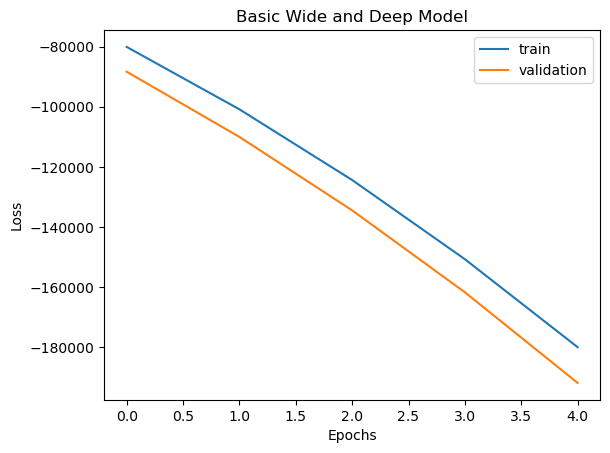

In [109]:
from matplotlib import pyplot as plt

# train using the already processed features
history = training_model.fit(
    preproc_ds_train, epochs=5, validation_data=preproc_ds_test, verbose=2
)

def plot_history(history, title):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history, 'Basic Wide and Deep Model')



From the raw data, the model has almost 25,000 parameters! That is a lot of parameters and could lead to longer computation times. To reduce dimensionality, we then passed into the TensorFlow model, and the gradient of the distances/connections of these feature-specific classes is solved, returning an output of a specified reduced size ($\sqrt{n}$) that still maintains the majority of the information from the original data. These approximations are the output of the feature space in the below code.

##### *'salary_currenecy'*
- - **Number of dimensions after reduction = $\sqrt{24} \approx 4$**
##### *'company_location'*
- - **Number of dimensions after reduction = $\sqrt{78} \approx 8$**
##### *'employee_residence'*
- **Number of dimensions after reduction = $\sqrt{89} \approx 9$**
##### *'job_title'*
- **Number of dimensions after reduction = $\sqrt{169} \approx 12$**

work_year <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_230>
remote_ratio <KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=keras_tensor_227>
experience_level <KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=keras_tensor_229>
company_size <KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=keras_tensor_228>


C:\Users\wschneider\anaconda3\envs\cs7324_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ company_location    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employee_residence  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employment_type     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_title           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salary_currency     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ company_location… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ employee_residen… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ employment_type[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ job_title[0][0]   │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ salary_currency[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ company_location_e… │ (None, 1, 8)      │        600 │ string_categoric… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employee_residence… │ (None, 1, 9)      │        747 │ string_categoric… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employment_type_em… │ (None, 1, 2)      │          8 │ string_categoric… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_title_embed     │ (None, 1, 12)     │      1,944 │ string_categoric… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salary_currency_em… │ (None, 1, 4)      │         88 │ string_categoric… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ work_year           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ remote_ratio        │ (None, 1)         │          0 │ -               

 Total params: 3,430 (13.40 KB)

 Trainable params: 3,427 (13.39 KB)

 Non-trainable params: 3 (16.00 B)

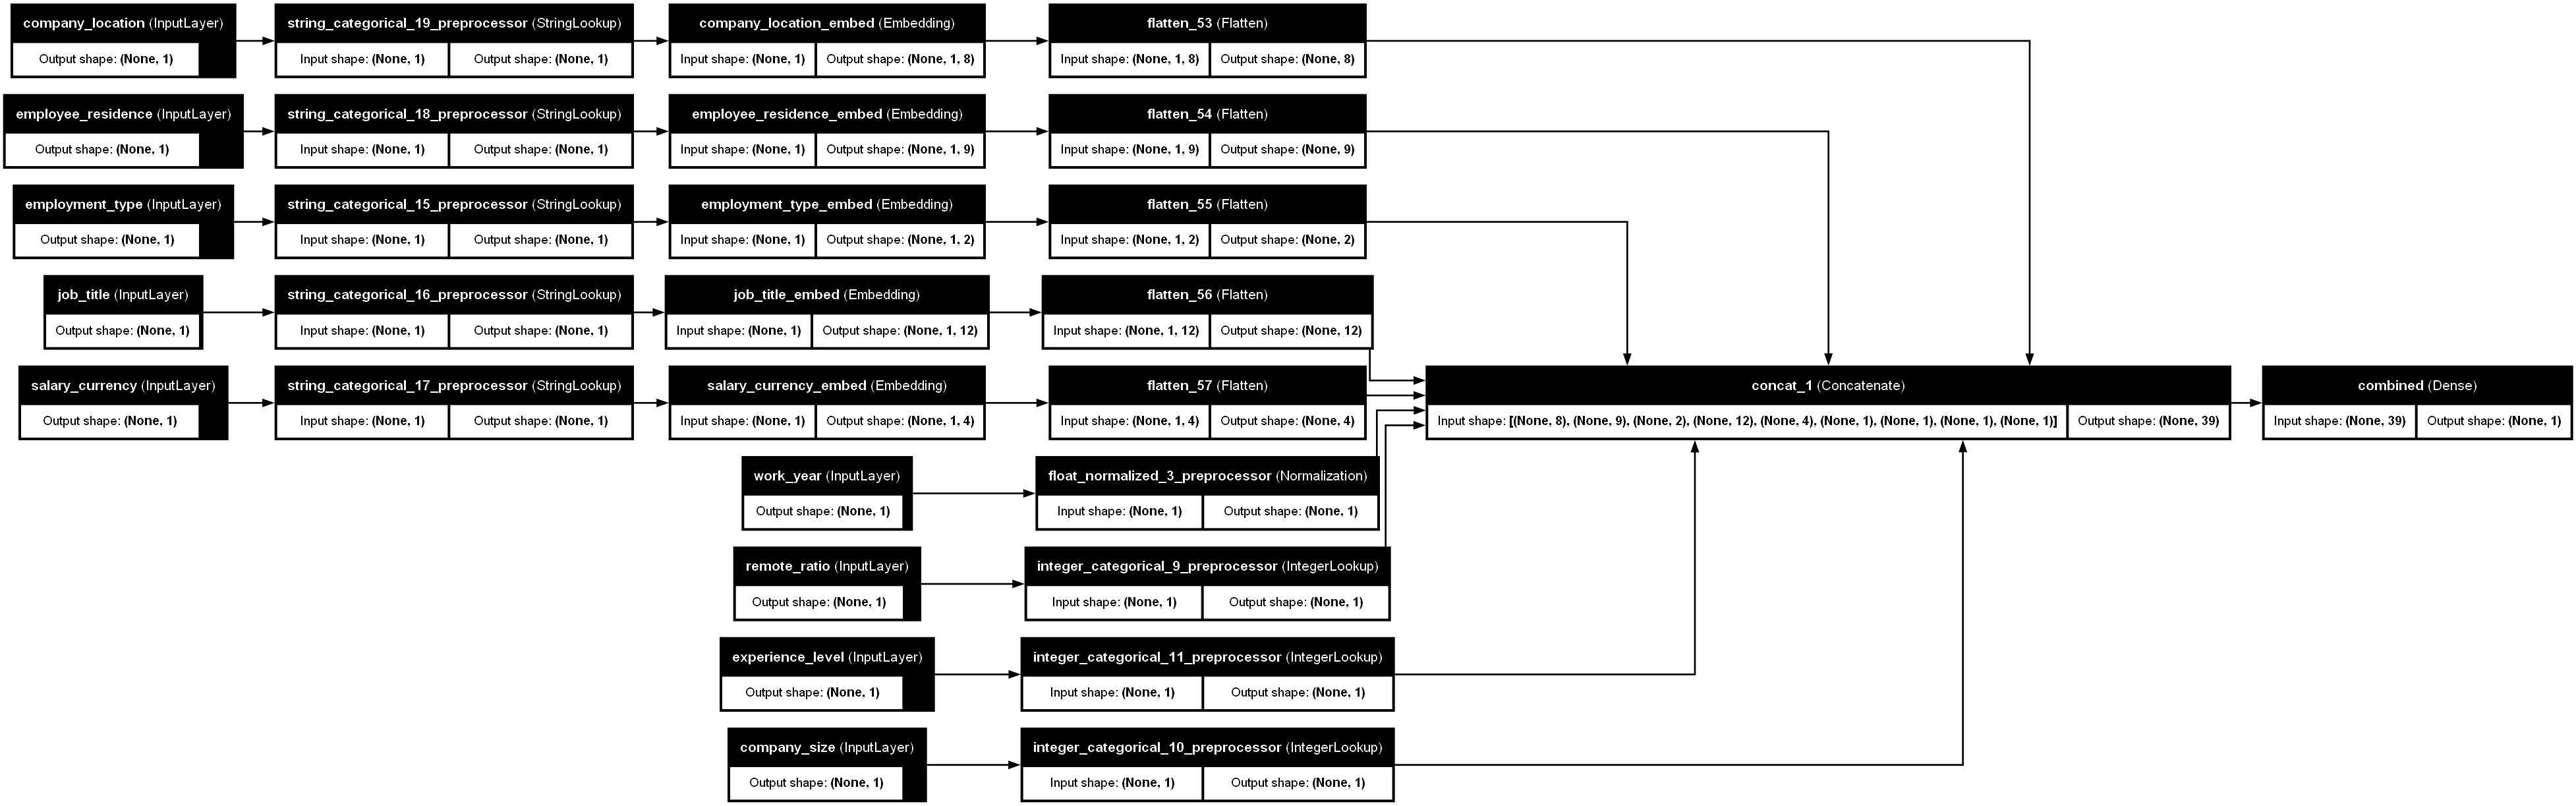

In [39]:
import warnings

# some lists for keeping track of parts of the model
all_branch_outputs = [] # this is where we will keep track of output of each branch

# for each categorical variable
for col in categorical_headers:
    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)
    # save these outputs in list to concatenate later
    all_branch_outputs.append(x)

dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

# for each numeric variable, just add it in after embedding
for col in numeric_headers:
    print(col,feature_space.preprocessors[col].output)
    x = feature_space.preprocessors[col].output
    # Cast the tensor to float within a Lambda layer
    # x = Lambda(lambda t: tf.cast(t, tf.float32))(x)
    all_branch_outputs.append(x)

# print(all_branch_outputs)
# now concatenate the outputs and add a fully connected layer
final_branch = Concatenate(name='concat_1')(all_branch_outputs)
final_branch = Dense(units=1,
                     activation='sigmoid',
                     name='combined')(final_branch)

# here, since we are accessing the string lookup data directly,
#. we cannot use the already processed data
training_model = keras.Model(inputs=dict_inputs,
                             outputs=final_branch)

training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

training_model.summary()

plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Thanks to dimensionality reduction, we reduced the number of parameters by about 7-fold. This reduction leaves us room to cross some of these features to build stronger connections in the model.

### 1.2 Crossed Features
#### 1 Employee Residence x Remote Ratio
- How is the salary in USD influenced by the employee's type of salary paid? This is probably a strong indicator of pay based on area. If the pay is not in USD, it might be more of a comtract role
- Total = 9 X 4 = 36
#### 2 Company Location x Company Size
- Companies in the US will probably be larger as it is the leading big tech country.
- Total = 9 * 3 = 27
#### 3 Job Title x Experience Level
- Specifics about each position (such as "Data Science Lead") suggest the experience/authority level
- Total = 13 * 4 = 52

In [40]:
from tensorflow.keras.utils import FeatureSpace

# Crossing columns together
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        # "experience_level": FeatureSpace.string_categorical(num_oov_indices=0),
        "employment_type": FeatureSpace.string_categorical(num_oov_indices=0,),
        "job_title": FeatureSpace.string_categorical(num_oov_indices=0),
        "salary_currency": FeatureSpace.string_categorical(num_oov_indices=0),
        "employee_residence": FeatureSpace.string_categorical(num_oov_indices=0),
        "company_location": FeatureSpace.string_categorical(num_oov_indices=0),

        # Categorical feature encoded as integers
        "remote_ratio": FeatureSpace.integer_categorical(num_oov_indices=0),
        "company_size": FeatureSpace.integer_categorical(num_oov_indices=0),
        "experience_level": FeatureSpace.integer_categorical(num_oov_indices=0),


        # Numerical features to normalize (normalization will be learned)
        # learns the mean, variance, and if to invert (3 parameters)
        # "salary_in_usd": FeatureSpace.float_normalized(),

        "work_year": FeatureSpace.float_normalized(),
            },
    # Specify feature cross with a custom crossing dim
    crosses=[
        FeatureSpace.cross(
            feature_names=('employee_residence','employment_type'), # dims: 9 x 3 x 4 = 108
            crossing_dim=9*3*4),
        FeatureSpace.cross(
            feature_names=('company_location','company_size'), # 8 x 3 = 24
            crossing_dim=8*3),
        FeatureSpace.cross(
            feature_names=('job_title','experience_level'), # 12 x 4 = 48
            crossing_dim=12*4),
    ],
    output_mode="concat",
)
# workclass has 7 unique values.
# education has 16 unique values.
# marital_status has 7 unique values.
# occupation has 14 unique values.
# relationship has 6 unique values.
# race has 5 unique values.
# sex has 2 unique values.
# country has 41 unique values.

# add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

def setup_embedding_from_crossing(feature_space, col_name):
    # what the maximum integer value for this variable?

    # get the size of the feature
    N = feature_space.crossers[col_name].num_bins
    x = feature_space.crossers[col_name].output


    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col_name+'_embed')(x)

    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)

    return x

9 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_301>


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ company_location    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employee_residence  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employment_type     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_title           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salary_currency     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ company_location… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ employee_residen… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ employment_type[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ job_title[0][0]   │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ salary_currency[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ work_year           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ remote_ratio        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ experience_level    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ company_size        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ company_location_e… │ (None, 1, 8)      │        600 │ string_categoric… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employee_residence… │ (None, 1, 9)      │        747 │ string_categoric… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ employment_type_em… │ (None, 1, 2)      │          8 │ string_categoric

 Total params: 8,420 (32.89 KB)

 Trainable params: 8,417 (32.88 KB)

 Non-trainable params: 3 (16.00 B)

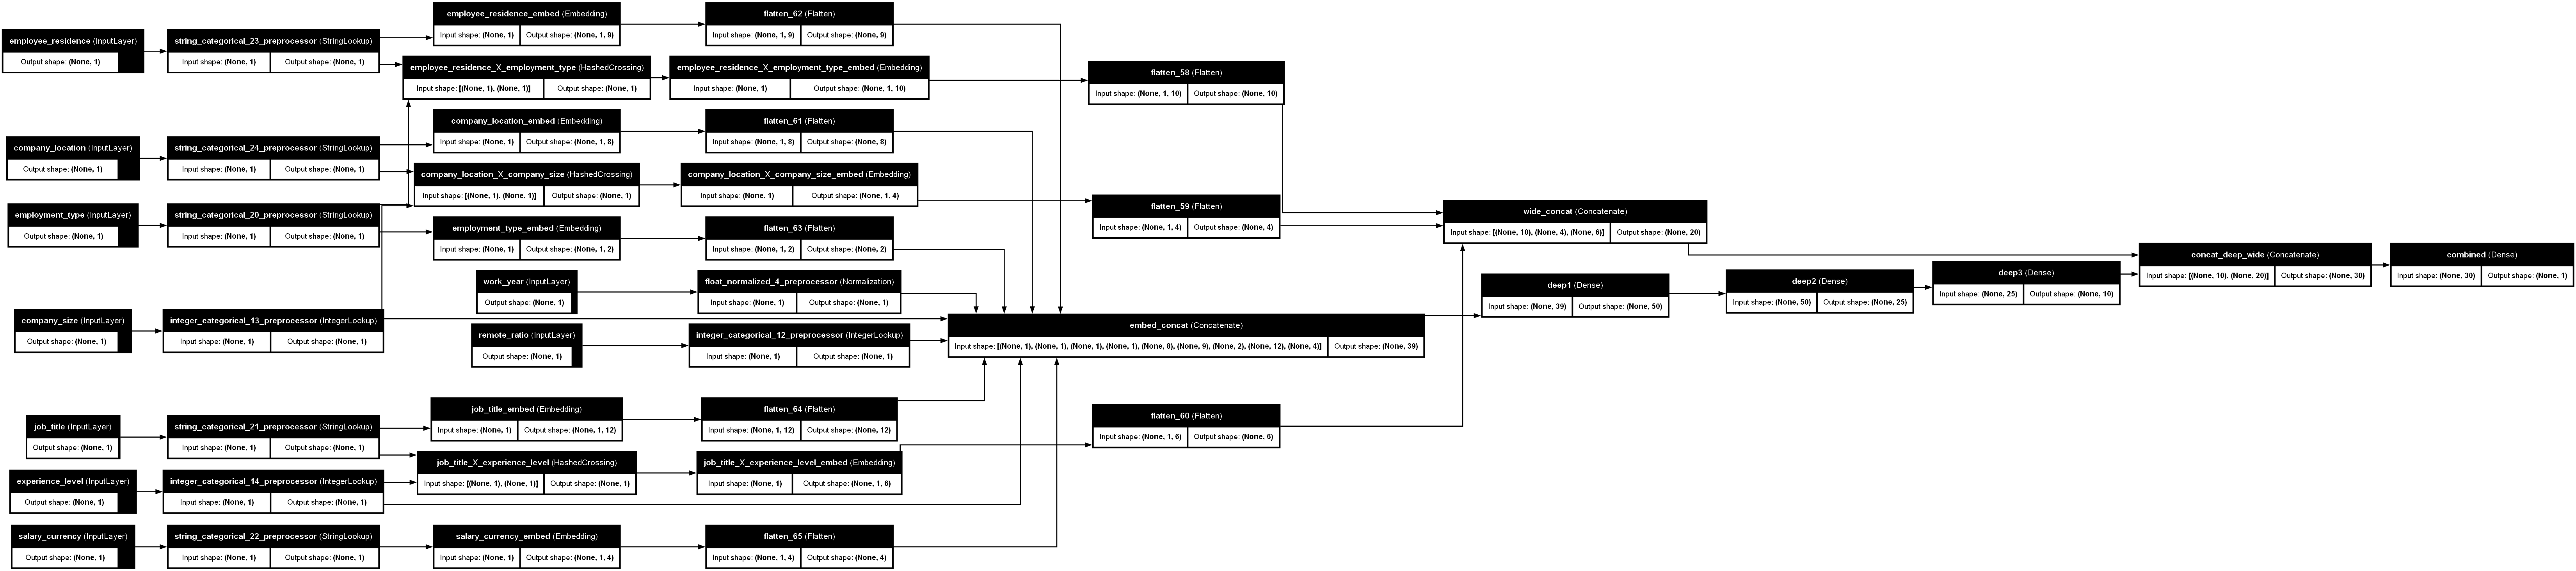

In [41]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output

# we need to create separate lists for each branch
crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():

    x = setup_embedding_from_crossing(feature_space, col)

    # save these outputs in list to concatenate later
    crossed_outputs.append(x)


# now concatenate the outputs and add a fully connected layer
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each numeric variable, just add it in after embedding
for idx,col in enumerate(numeric_headers):
    x = feature_space.preprocessors[col].output
    # x = tf.cast(132,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:

    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)

    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)


# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)

# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)
print(len(dict_inputs), final_branch)
training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

training_model.summary()

plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [87]:
history1 = training_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


def plot_history(history, title):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history1, 'Basic Wide and Deep Model')

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [45]:
X_train.toarray()

AttributeError: 'DataFrame' object has no attribute 'toarray'

### 1.3 Evaluation Metrics

### 1.4 Data Splitting